Modeling Temperature based off greenhouse gases


We have scraping code to get all the data, but not included in here as there was parsing afterwards to make sure the data was correct.  May include at end of notebook to show how the data was taken.

The WorldController class is used to parse weather data.

In [1]:
from datetime import datetime
import pandas as pd
import glob
import numpy as np
from StateObj import StateObj, findState
from matplotlib import pyplot
from DataModifier import DateMod
#change this class to contioulsy run in future.

##MAIN##

## CREATE/PARSE DATA FOR ML MODEL##


##CREATE OBJECTS FOR EACH CITY##
## City obj will handle data passed in through none statements
#CountryObj() # only do UNITED STATES
class WorldController:
    def __init__(self, oo = False):
        if oo:
            cityCountryDict = {}
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt', infer_datetime_format=True)
                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States' ]

                weatherGroup = weatherCityData.groupby(['Longitude', 'Latitude'])

                for  key, item in weatherGroup:
                    for city in item.City.unique():
                        cityCountryDict[city]   =  {'Location': [*item.Longitude.unique(), *item.Latitude.unique()]}
                # remove break

            allWeatherCityData = pd.DataFrame()
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt')

                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States']
                weatherCityData.index = pd.to_datetime(weatherCityData.index)
                weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
                weatherCityData = weatherCityData[weatherCityData.index.year < 2012]
                allWeatherCityData = allWeatherCityData.append(weatherCityData)
                for key in cityCountryDict.keys():
                    #pd.DataFrame(weatherCityData['AverageTemperature'].resample('W').sum(), columns=['AverageTemperature'])
                    weatherDict = weatherCityData[weatherCityData['City'] == key]['AverageTemperature']
                    i = 0
                    cityCountryDict[key]['time'] = []
                    for date in weatherDict.index.to_pydatetime():
                        otherDict = {date.strftime("%Y-%m-%d"): weatherDict.values[i]}
                        cityCountryDict[key]['time'].append(otherDict)
                        i+=1
                # remove break

            #cityCountryDict has City as key, Location : [longitude, latitude], time: [{WEEK TIMESTAMP : weather}...*]. Each child will find data to fit with its parent classes to pass data to it.  (read the csv, etc.)
            allStateData = pd.read_csv('./data/weather/GlobalLandTemperaturesByState.csv')
            allStateData = allStateData[allStateData['Country'] =='United States']
            allStateData.dt = pd.to_datetime(allStateData.dt)
            allStateData = allStateData.set_index(drop=True, keys='dt')

            #get weather data from 1960 and above.
            allStateData = allStateData[allStateData.index.year>=1960]#.resample('W').mean()['AverageTemperature']
            allStateData = allStateData[allStateData.index.year<2012]
            allStates = []
            for state in allStateData['State'].unique():
                otherData = allStateData[allStateData['State'] == state]
                allStates.append(StateObj(state, otherData))


            for city in cityCountryDict.keys():
                 cityStateName = findState(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1])
                 for state in allStates:
                     if cityStateName == state.getStateName():
                         state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                         #need this break.  Found the state.
                         break
                     if cityStateName == 'StateNA':
                         state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                         break


            # this is only class attribute that will be used
            self.states = allStates
            self.longLat = weatherCityData


        else:
            weatherCityData = pd.read_csv('./data/weather/unitedStatesTemp.csv', header=0, index_col='dt')
            weatherCityData.index = pd.to_datetime(weatherCityData.index)
            weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
            weatherCityData = weatherCityData[weatherCityData.index.year <= 2012]
            weatherCityData.Latitude = weatherCityData.Latitude.apply(parseLat)
            weatherCityData.Longitude = weatherCityData.Longitude.apply(parseLong)

            self.monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for name, group in weatherCityData.groupby(by=[weatherCityData.index.month]):

                self.monthDict[group.index[0].month] = group
            #print (monthDict)
            averageMonthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for dataFrame in self.monthDict.keys():
                averageMonthDict[dataFrame] = self.monthDict[dataFrame].groupby(by=self.monthDict[dataFrame].index).agg('mean')['AverageTemperature']
            #monthDict[1].to_csv('month1 temperatures')
            self.graphMonthlyChange(averageMonthDict)
            self.calculatePerIncrease(averageMonthDict)

        




    def calculatePerIncrease(self, aDict):
        for key in aDict.keys():
            print('%increase for month {}  == {}'.format(key, ((aDict[key][-1] - aDict[key][0])/aDict[key][0])*100 ) )


    def graphMonthlyChange(self, aDict):
        for key in aDict.keys():
            pyplot.plot(aDict[key], label=key)
        #pyplot.plot(graphed)
        pyplot.xlabel('Years')
        pyplot.ylabel('Temperature in Celsius')
        pyplot.legend()
        pyplot.savefig('./generatedData/monthDataWithlegend')

        pyplot.figure().clear()

    def getDfToTrain(self,sf6, n2o, co2, ch4):
        sf6 = self.createMonthYear(sf6)
        n2o = self.createMonthYear(n2o)
        co2 = self.createMonthYear(co2)
        ch4 = self.createMonthYear(ch4)
        dfMonthArray = []
        for keys in self.monthDict:
            month1 = pd.DataFrame(self.monthDict[keys][['AverageTemperature', 'Latitude', 'Longitude']])
            month1['sf6'] = np.nan
            month1['n2o'] = np.nan
            month1['co2'] = np.nan
            month1['ch4'] = np.nan
            monthParsed = month1.reset_index()
            i =0
            for index, row in monthParsed.iterrows():
                #print(sf6.loc[index.date()].values[0])
                ymRow = "{}/{}".format(row['dt'].year, row['dt'].month)
                month1['sf6'].iloc[i] = sf6[sf6['index'] == ymRow]['average'].values[0]
                month1['n2o'].iloc[i] = n2o[n2o['index'] == ymRow]['average'].values[0]
                month1['co2'].iloc[i] = co2[co2['index'] == ymRow]['CarbonEmissions'].values[0]
                month1['ch4'].iloc[i] = ch4[ch4['index'] == ymRow]['sum'].values[0]
                i+=1
            month1.reset_index(drop=True, inplace=True)
            dfMonthArray.append(month1)
        return dfMonthArray

    def getMonthDict(self):
        return self.monthDict
    
    def createMonthYear(self, df):
        sf6YearMonth = []
        for i in range(0, len(df.index.year)):
            sf6YearMonth.append('{}/{}'.format(df.index[i].year, df.index[i].month ))
        df = df.reset_index()
        df['index'] = pd.Series(sf6YearMonth)
        return df

    def train_state_models(self):
        stateModel = "" # should be linear/log model
        for state in self.states:
            #get each state name, use it in conjuncation with the greenhouse gasses.
            state.getStateName()
        return stateModel

    def train_city_models(self):
        pass
def parseLong( longitude): #east negative
    if 'E' in longitude:
        return   float(longitude.replace('E', ''))
    else:
        return (-1) * float(longitude.replace('W', ''))

def parseLat( latitude): #north south
    if 'S' in latitude:
        return  (-1) *float(latitude.replace('S', ''))
    else:
        return float(latitude.replace('N', ''))
## Right here, create ML model.


##


#Once city populated, inf. while loop to get input for a city/state/country day(the next days sf6/co2/ch4/etc
# levels will be calculted and put into the model we have trained to predict #
#given a day, calculate greenhouse level gasses from our formula, and input to city params to be processed with given data
#if __name__ == "__main__":
#    WorldController()



Here we have created an object that stores three dataframes when used. One for months, days, and weeks in case we want to use different types of time periods for predictions.  

In [2]:
import pandas as pd
import glob
from calendar import monthrange
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
class DateMod():
    yearDataFrame = None
    monthDataFrame = None
    weekDataFrame = None
    dayDataFrame = None
    def __init__(self, df, colValName):
        if "month" in df.keys():
            self.month_to_days(df,colValName)
        elif 'year' in df.keys():
            self.year_to_days(df,colValName)
        #TODO: fill in nan values created from months_to_day (They will = 0) to predicted ones.
    # testing on ch4, go up to 2014
    #returns dataframe with datetime as index, and values for each day given
    def year_to_days(self,df, colValName):
        dateObjs = []
        dateVals = []
        for i, y in enumerate(df.year):
            if y >= 1960:
                start = dt.date(y, 1, 1)
                end = dt.date(y+1,1, 1)
                date = start
                days = (end - start).days
                value = df[colValName][i]
                while date != end:
                    dateObjs.append(date)
                    dateVals.append(value/days)
                    date += dt.timedelta(days=1)
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        df.index = pd.to_datetime(df.index)
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])
    def month_to_days(self, df, colValName):
        dateObjs = []
        dateVals = []
        if int(df.year[0]) > 1960:

            diff = int(df.year[0]) - 1960
            # find delta, and append to month range list

            for year in range(diff+1):
                for month in range(1, 13):
                    # check if current year needs months added
                    if 1960+year == int(df.year[0]) and int(df.month[0]) == month:
                        break
                    for days in range(1, (monthrange(int(df.year[0]) + year, month)[1])):
                        dateObjs.append(dt.datetime(1960+year, month, days))
                        dateVals.append(np.nan)
        # add known dates to monthrange
        for index, row in df.iterrows():
            # check if row and month exist in delta time, if it doesn't add it.

            numDaysInMonth = (monthrange(int(row['year']), int(row['month']))[1])
            valueToAppendToDay = int(row[colValName])/numDaysInMonth
            for days in range(1, numDaysInMonth+1):
                dateObjs.append(dt.datetime(int(row['year']), int(row['month']), days))
                dateVals.append(valueToAppendToDay)

        # TODO HERE:  add dates after the end date of the given df to equal 2019.... maybe..
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        Y = regrade_lin([x for x in range(len(df[colValName].values.tolist()))],df[colValName].values.tolist())
        for val in Y:
            if val > 0:
                try:
                    foo = 1/val
                except ZeroDivisionError:
                    continue
                set = val
                break
        for i, v in enumerate(Y):
            if v < 0.0000001 or v == 0:
                Y[i] = set
        df[colValName] = Y
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])

    def graphMonths(self, name):
        plt.plot(self.monthDataFrame)
        plt.savefig('/generatedData/{}_month_graph'.format(name))
        plt.figure().clear()
    def graphWeeks(self,name):
        plt.plot(self.weekDataFrame)
        plt.savefig('/generatedData/{}_weeks_graph'.format(name))
        plt.figure().clear()
    def graphDays(self,name):
        plt.plot(self.dayDataFrame)
        plt.savefig('/generatedData/{}_days_graph'.format(name))
        plt.figure().clear()

def regrade_lin(x, y):#returns the missing values of y
    missing = []
    n = 0
    sumx = 0
    sumy = 0
    sum_prodxy = 0
    sum_squarex = 0
    sum_squarey = 0
    for i,v in enumerate(y):
        if pd.isna(v) or pd.isna(x[i]):
            missing.append(i)
        if not pd.isna(v) and not pd.isna(x[i]):
            n+=1
            sumx += x[i]
            sumy += v
            sum_prodxy += x[i]*v
            sum_squarex += x[i]**2
            sum_squarey += v**2
    #some method from the internet
    #a = (sumy*sum_squarex - sumx*sum_prodxy)/(n*sum_squarex - sumx**2)
    #b = (n*sum_prodxy - sumx*sumy)/(n*sum_squarex - sumx**2)
    #method of least squares
    b = (sum_prodxy-(sumx*sumy)/n)/(sum_squarex-(sumx**2)/n)#b1
    a = (1/n)*(sumy - b*sumx)#b0
    #y = a + bx
    #x = (y - a)/b
    for i in missing:
        if pd.isna(x[i]):
            x[i] = (y[i] - a)/b
        else:
            y[i] = a + b*x[i]
    return y

def IPA(df):#value Increase in Percentage Averaged over intervals
    ratios = []
    interval = [] 
    for i,new in enumerate(df):
        if i != 0:
            ratios.append(((new-old)/old)*100)
        old = new
    #(len(ratios))
    avg = sum(ratios)/len(ratios)
    return [ratios,interval]
# if called from main, we want to test this file, so create dataframes and pass em in.
# TODO: might want to put graph_all, and graph_weekly into new class, along with our training models.
def test_code(debug):
    sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
    sf6_obj = DateMod(sf6_data, 'average')
    n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
    n2o_obj = DateMod(n2o_data, 'average')


    listOfCh4 = []
    i = 0
    for file in glob.glob('./data/Ch4/*'):
        ch4_data = pd.read_csv(file, header=0)
        listOfCh4.append(DateMod(ch4_data, 'value'))

        if i==10:
            break
        i+=1
    joinedCH4 = pd.DataFrame()
    # concat all dataframes we made, and create sum
    for ch4DataFrame in listOfCh4:
        joinedCH4 = pd.concat([joinedCH4, ch4DataFrame.monthDataFrame], axis=1)

    # aggregate each column to get sum of all of the files we scraped.
    joinedCH4 = joinedCH4.agg('sum',axis=1)


    # Don't know how to do these conversion.  Need help.
    co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)


def usage():
    print('python DataModifier [-d]')




##MAIN METHOD##
#if __name__ == '__main__':
#    import getopt
#    import sys
#    debug = False
#    try:
#        opt, args = getopt.getopt(sys.argv[1:], "d")
#    except getopt.GetoptError:
#        usage()
#        sys.exit(2)
#    for opts, arg in opt:
#        if opts == '-d':
#            debug = True
#
#
#    test_code(debug)


This is our MAIN Class that gathers all greenhouse gas data and parses through it.  
It creates a WorldController Obj that we will use to get our trained models once we call the train methods.  


In [3]:
from WorldController import WorldController
from DataModifier import DateMod, IPA
import pandas as pd
import glob
# worldController takes care of temperature/longitude
#datamodifer is used to modify other data

def convertDFIntoMonthDict(dataFrame):
    monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
    for name, group in dataFrame.groupby(by=[dataFrame.index.month]):
        monthDict[group.index[0].month] = group
    return monthDict

sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
sf6_obj = DateMod(sf6_data, 'average')
sf6_dict = convertDFIntoMonthDict(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <2012])

sf6_obj.monthDataFrame.to_csv('sf6_month_data')

n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
n2o_obj = DateMod(n2o_data, 'average')
n2o_obj.monthDataFrame.to_csv('N20_month_data')
n2o_dict = convertDFIntoMonthDict(n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <2012])

listOfCh4 = []
i = 0
for file in glob.glob('./data/Ch4/*'):
    ch4_data = pd.read_csv(file, header=0)
    listOfCh4.append(DateMod(ch4_data, 'value'))

    if i==10:
        break
    i+=1
joinedCH4 = pd.DataFrame()
# concat all dataframes we made, and create sum
for ch4DataFrame in listOfCh4:
    joinedCH4 = pd.concat([joinedCH4, ch4DataFrame.monthDataFrame], axis=1)


# aggregate each column to get sum of all of the files we scraped.
joinedCH4 = joinedCH4.agg('sum',axis=1)
joinedCH4 = joinedCH4.to_frame().reset_index().rename(columns={'index':'month',0:'sum'})
CH4_year = []
CH4_month = []
for date in joinedCH4.month:
    CH4_year.append(date.year)
    CH4_month.append(date.month)
joinedCH4.month = CH4_month
joinedCH4['year'] = CH4_year
CH4_obj = DateMod(joinedCH4, 'sum')

ch4_dict = convertDFIntoMonthDict(CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <2012])
#print(CH4_obj.dayDataFrame)
joinedCH4.to_csv('CH4_month_data')

# Don't know how to do these conversion.  Need help.
#ignoring the per capita data, we will use the yearly carbon emmision data and divide it into days then weeks and months
co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)
co2_data = co2_data.rename(columns={'Year':'year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)':'CarbonEmissions'})
co2_data = co2_data.loc[:,['year','CarbonEmissions']]
co2_data = co2_data.drop(co2_data.index[0]).reset_index(drop=True)
co2_data = co2_data.apply(pd.to_numeric)
co2_obj = DateMod(co2_data,'CarbonEmissions')
#print(joinedCH4)
co2_dict = convertDFIntoMonthDict(co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <2012])


greenhouse = [sf6_obj,n2o_obj,CH4_obj, co2_obj]
for obj in greenhouse:
    #print(IPA(obj.monthDataFrame[obj.monthDataFrame.keys().tolist()[0]]))
    pass
# initialize weather data into objs.



    #nitDf = pd.DataFrame()
    #allWeatherLongLat =  pd.concat(allWeatherLongLat, initDf)
    #print(allWeatherLongLat)
#self,sf6, n2o, co2, ch4

#mainControl.train_long_lat_model(None,None,None,None)




%increase for month 1  == 162.10702888102324
%increase for month 2  == 60.456368660308236
%increase for month 3  == 95.74984604281802
%increase for month 4  == 2.4541743829573344
%increase for month 5  == 13.997910454461774
%increase for month 6  == 1.4016863609385102
%increase for month 7  == 5.59492722416054
%increase for month 8  == 4.531561038568017
%increase for month 9  == 0.5381594228514223
%increase for month 10  == 0.9738950150704943
%increase for month 11  == 1.1735419234242528
%increase for month 12  == 82.65580255660811


E:\Interpreters\Anaconda3.0\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


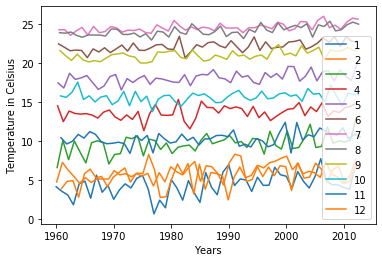

<Figure size 432x288 with 0 Axes>

In [4]:
mainControl = WorldController()

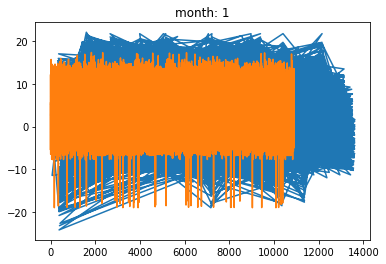

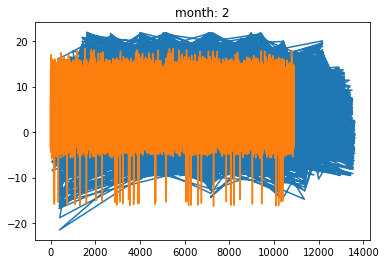

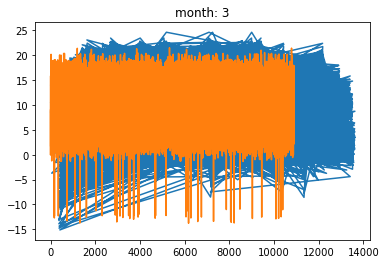

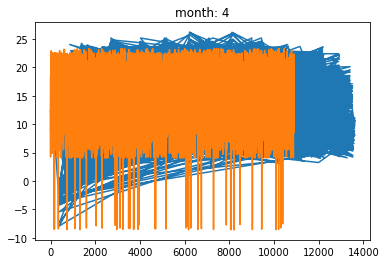

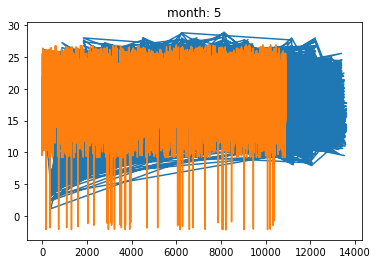

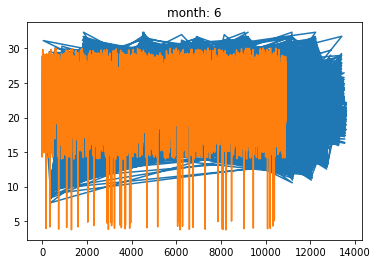

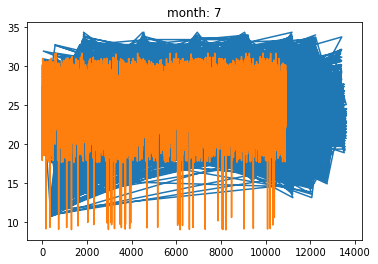

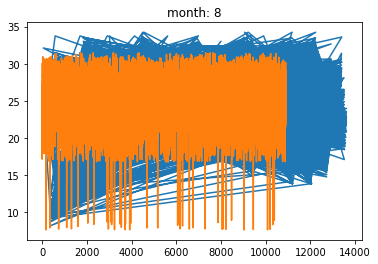

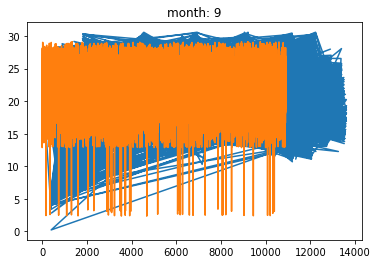

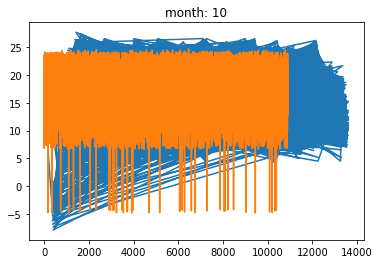

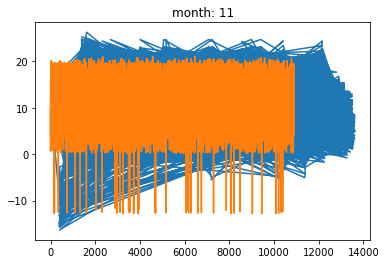

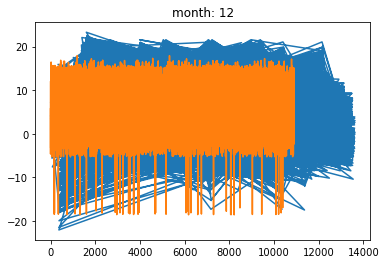

In [5]:
arrayOfDataToTrain = mainControl.getDfToTrain(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2012], n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2012], co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <=2012], CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2012])
    
#now we have an array with dataframes for each month, return several models.  One for each month.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
linearModel = []
i = 1
for df in arrayOfDataToTrain:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    linMod = LinearRegression().fit(X_train, y_train)
    linearModel.append(linMod)
    plt.title(f'month: {i}')
    plt.plot(y_test, label='real')
    plt.plot(linMod.predict(X_test), label='predicted')
    plt.show()
    i+=1



In [6]:
for i in range(len(arrayOfDataToTrain)):
    x =  arrayOfDataToTrain[i][arrayOfDataToTrain[i].columns[1:]]
    y = arrayOfDataToTrain[i][arrayOfDataToTrain[i].columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    print(pd.DataFrame([y_test.values,linearModel[i].predict(X_test)]))
    #print('Actual:{} Precited:{}'.format(y_test.values,linearModel[i].predict(X_test)))
    #print(y_test)
    #print(y_test)

      0         1          2          3          4         5         6      \
0  3.251000  3.266000  13.301000  10.129000   4.771000 -0.412000  7.584000   
1  5.534027 -5.457173  12.179195   7.403322  12.082468  0.679378  8.530406   

      7         8         9      ...     10887      10888     10889     10890  \
0 -4.572000  4.138000  6.947000  ... -5.012000  14.146000 -8.830000  0.352000   
1 -6.446101  5.533125  8.031591  ... -2.306901  12.140884  0.254263 -0.432439   

      10891     10892      10893      10894     10895     10896  
0  8.238000  8.238000   9.808000  19.180000  7.428000  3.522000  
1  5.763902  5.763902  12.675161  13.572446  9.238374  2.320501  

[2 rows x 10897 columns]
      0         1          2          3          4         5          6      \
0  5.031000  4.377000  14.758000  10.359000   7.242000  3.435000  10.261000   
1  7.381786 -3.552038  12.611156   8.674631  13.740821  1.780105   9.629709   

      7         8          9      ...     10887      10888 

So something went wrong, before we move on, we are going to check the correlation of the data we currently have.  Next step is to try and gather more data that can be used for weather predictions.

In [7]:
print(arrayOfDataToTrain[0].columns)

arrayOfDataToTrain[0].corr()[['AverageTemperature']].sort_values('AverageTemperature')


Index(['AverageTemperature', 'Latitude', 'Longitude', 'sf6', 'n2o', 'co2',
       'ch4'],
      dtype='object')


,AverageTemperature
Latitude,-0.821355
Longitude,-0.331798
ch4,-0.026862
co2,0.072663
n2o,0.078162
sf6,0.078989
AverageTemperature,1.000000


0       -100.53
1       -100.53
2       -100.53
3       -100.53
4       -100.53
5       -100.53
6       -100.53
7       -100.53
8       -100.53
9       -100.53
10      -100.53
11      -100.53
12      -100.53
13      -100.53
14      -100.53
15      -100.53
16      -100.53
17      -100.53
18      -100.53
19      -100.53
20      -100.53
21      -100.53
22      -100.53
23      -100.53
24      -100.53
25      -100.53
26      -100.53
27      -100.53
28      -100.53
29      -100.53
          ...  
13591    -74.56
13592    -74.56
13593    -74.56
13594    -74.56
13595    -74.56
13596    -74.56
13597    -74.56
13598    -74.56
13599    -74.56
13600    -74.56
13601    -74.56
13602    -74.56
13603    -74.56
13604    -74.56
13605    -74.56
13606    -74.56
13607    -74.56
13608    -74.56
13609    -74.56
13610    -74.56
13611    -74.56
13612    -74.56
13613    -74.56
13614    -74.56
13615    -74.56
13616    -74.56
13617    -74.56
13618    -74.56
13619    -74.56
13620    -74.56
Name: Longitude, Length:

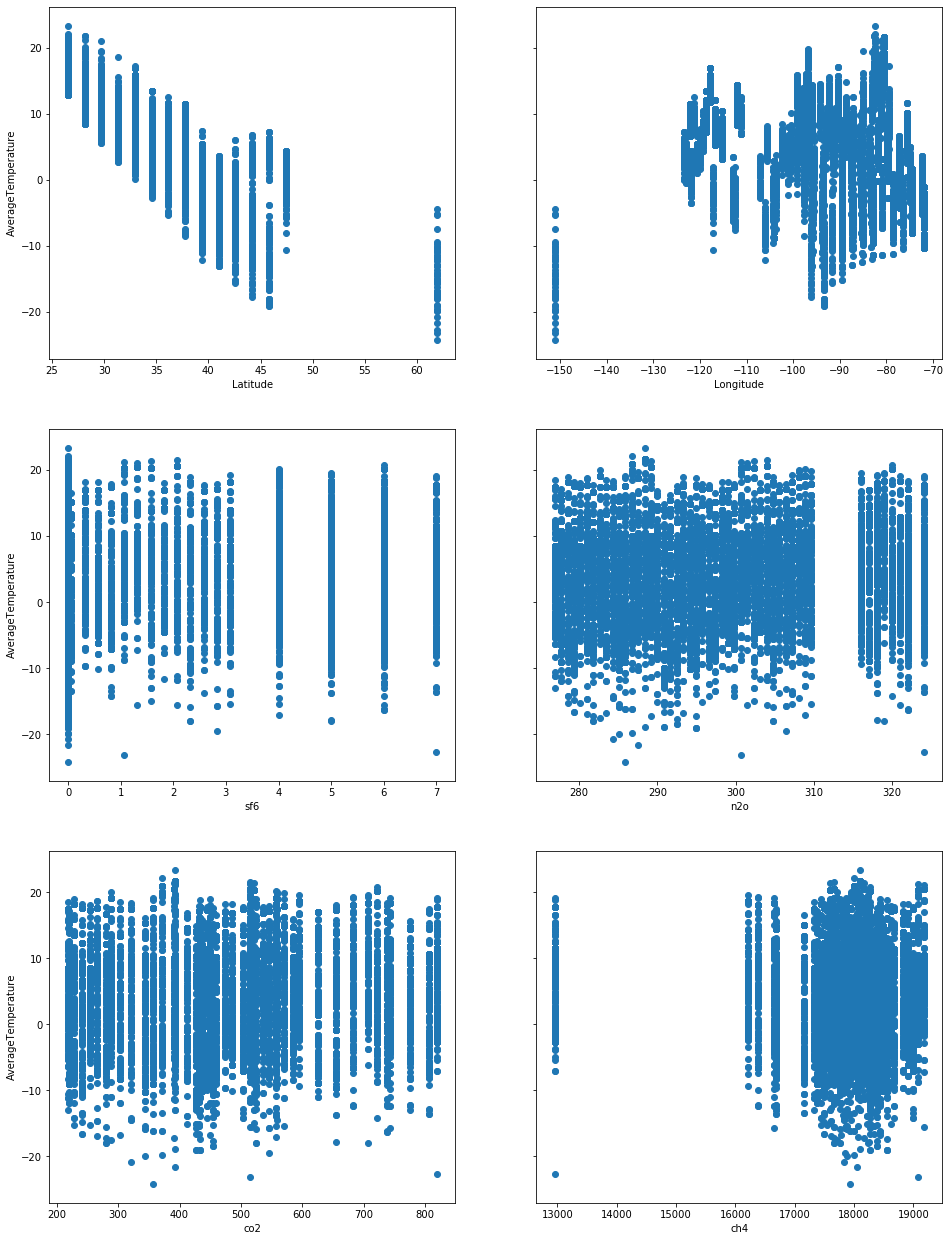

In [8]:
predictors = arrayOfDataToTrain[0].columns[1:].to_list()

df2 = arrayOfDataToTrain[0][['AverageTemperature'] + predictors]
print(arrayOfDataToTrain[0].Longitude)
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(3, 2)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['AverageTemperature'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='AverageTemperature')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

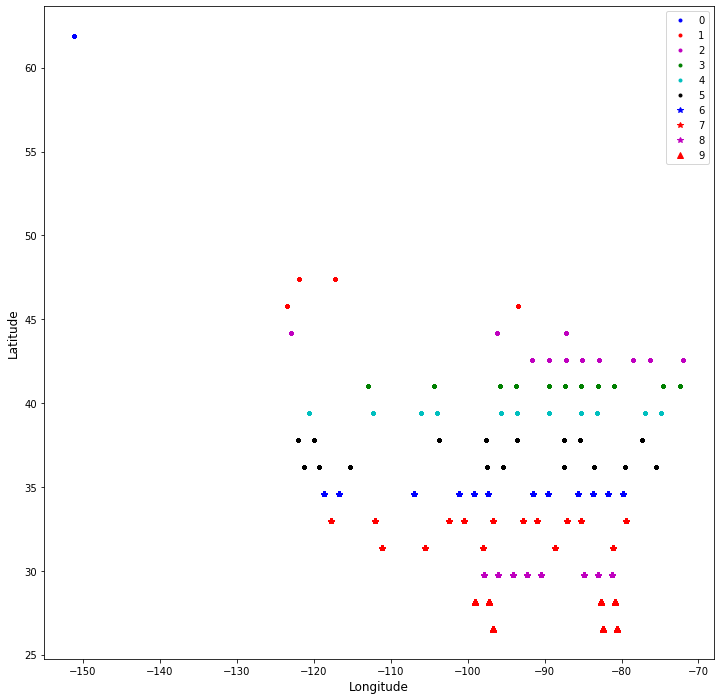

In [101]:
#from geohash2 import encode
#for df in arrayOfDataToTrain:
#    for index, row in df.iterrows():
#        print(encode(row['Latitude'],row['Longitude'], precision=2))

#datafile = cbook.get_sample_data('E:\OneDrive - University of Georgia\Data Science\project\usa.jpg')
#img = imread("E:/OneDrive - University of Georgia/Data Science/project/usa.jpg")

from sklearn.cluster import KMeans
id_n= 10
j = 0 
for df in arrayOfDataToTrain:
    X = df.loc[:, ['Longitude', 'Latitude']]

    kmeans = KMeans(n_clusters=id_n, random_state=0).fit(np.array(X.loc[:,'Latitude'].to_list()).reshape(-1,1))
    #kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
    ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^'])
    myArray = np.zeros(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
        if kmeans.labels_[i] == 0:
            myArray[i] = 7
        elif kmeans.labels_[i] == 1:
            myArray[i] = 3
        elif kmeans.labels_[i] == 2:
            myArray[i] = 9
        elif kmeans.labels_[i] == 3:
            myArray[i] = 1
        elif kmeans.labels_[i] == 4:
            myArray[i] = 5
        elif kmeans.labels_[i] == 5:
            myArray[i] = 0
        elif kmeans.labels_[i] == 6:
            myArray[i] = 2
        elif kmeans.labels_[i] == 7:
            myArray[i] = 8
        elif kmeans.labels_[i] == 8:
            myArray[i] = 4
        elif kmeans.labels_[i] == 9:
            myArray[i] = 6
    df['LongLat'] = myArray
    id_label = myArray
    if j == 0:
        plt.figure(figsize=(12,12))
        plt.ylabel('Latitude', fontsize=12)
        plt.xlabel('Longitude', fontsize=12)
        arrayOfClusters = []
        for i in range(id_n):

            cluster=np.where(id_label==i)[0]
            plt.plot(X.Longitude[cluster].values,X.Latitude[cluster].values ,ptsymb[i], label=i)
        plt.legend()
        plt.show()
    j+=1


So, predicting temperature with greenhouse gases may not have been the best idea.  So let us try to use the data we do have by predicting how climate change will change.  

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

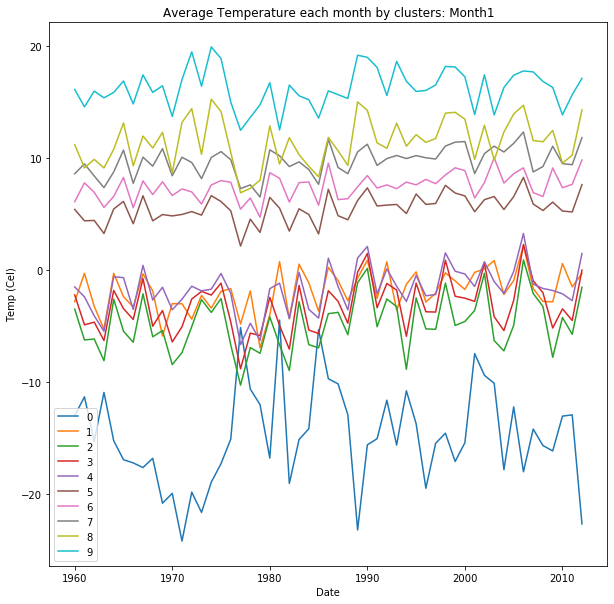

<Figure size 720x720 with 0 Axes>

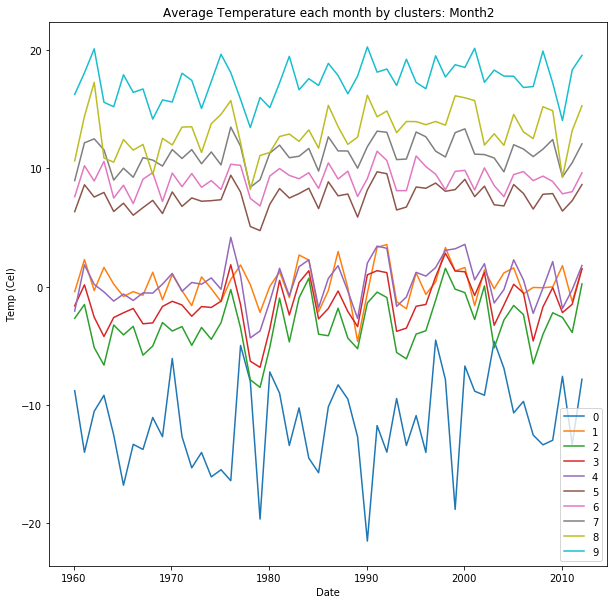

<Figure size 720x720 with 0 Axes>

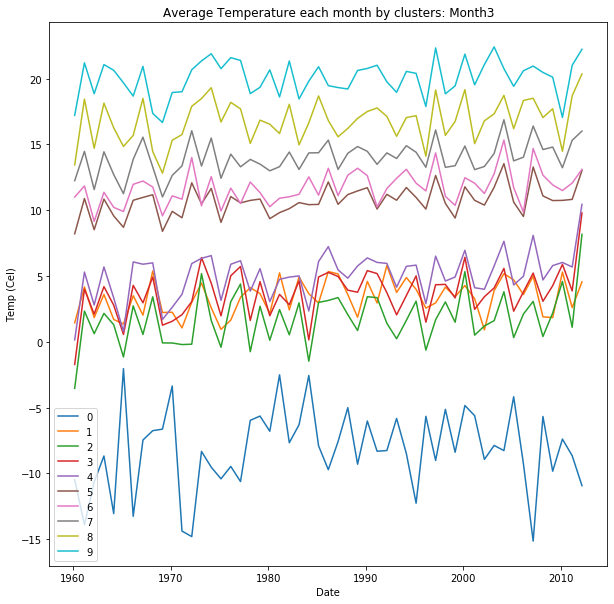

<Figure size 720x720 with 0 Axes>

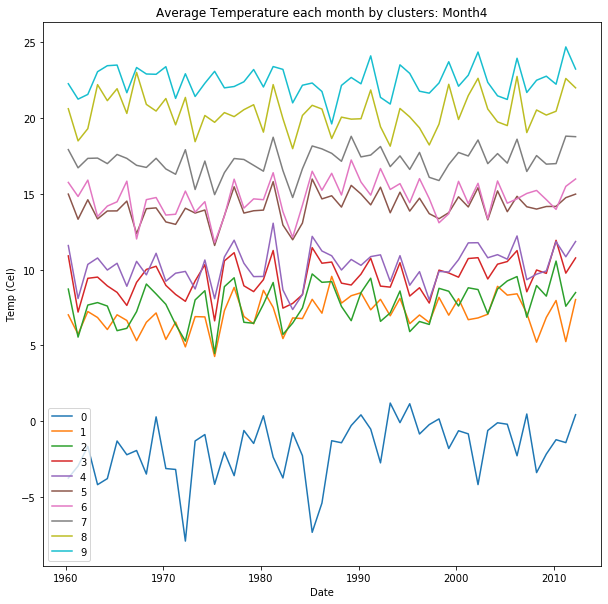

<Figure size 720x720 with 0 Axes>

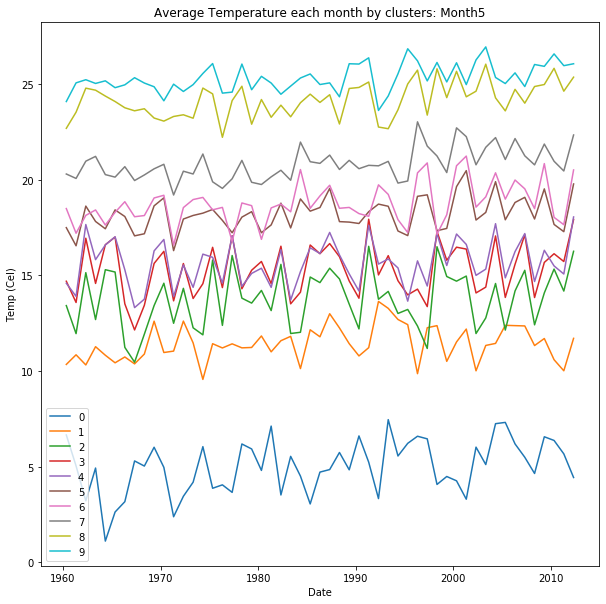

<Figure size 720x720 with 0 Axes>

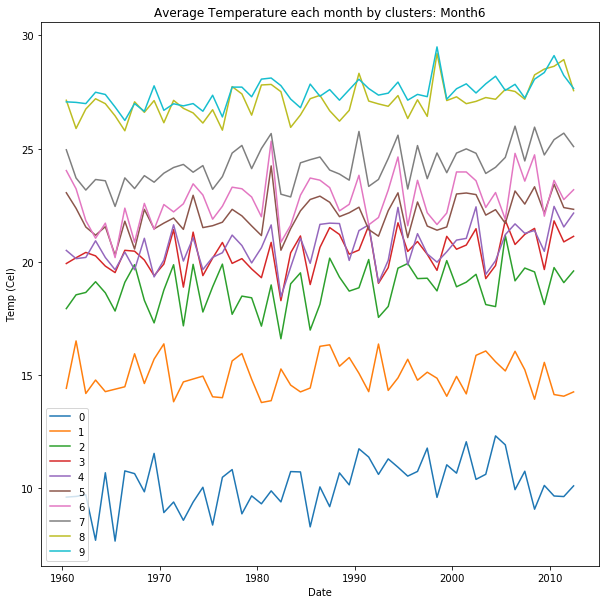

<Figure size 720x720 with 0 Axes>

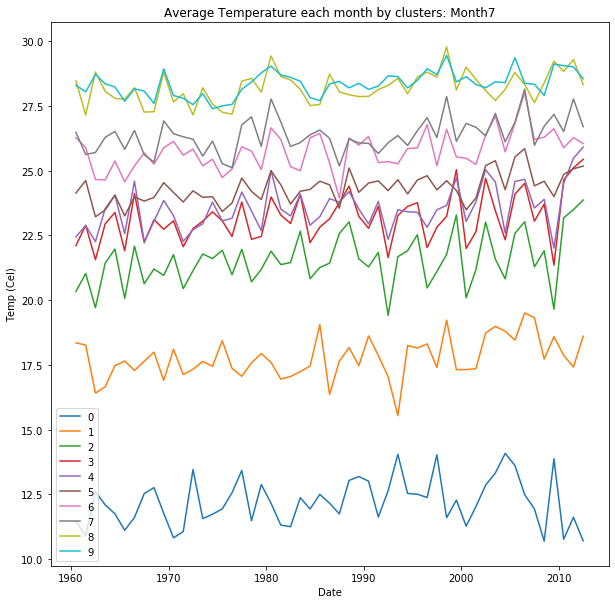

<Figure size 720x720 with 0 Axes>

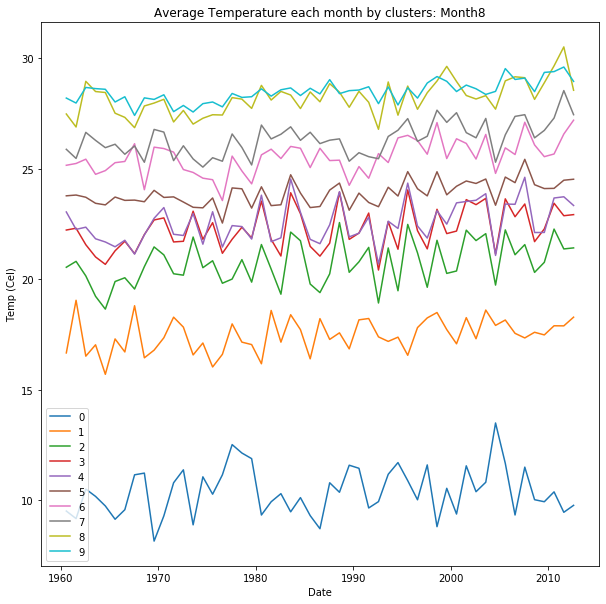

<Figure size 720x720 with 0 Axes>

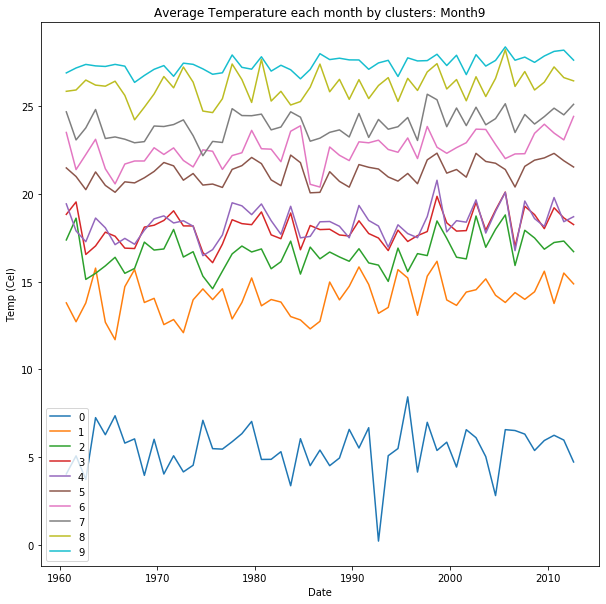

<Figure size 720x720 with 0 Axes>

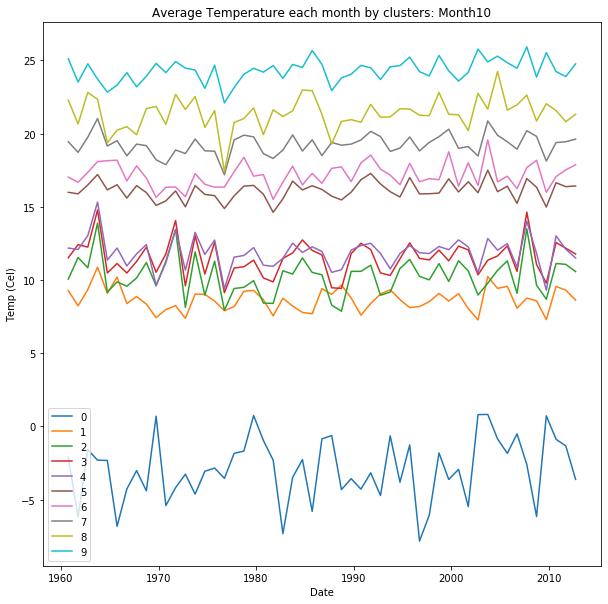

<Figure size 720x720 with 0 Axes>

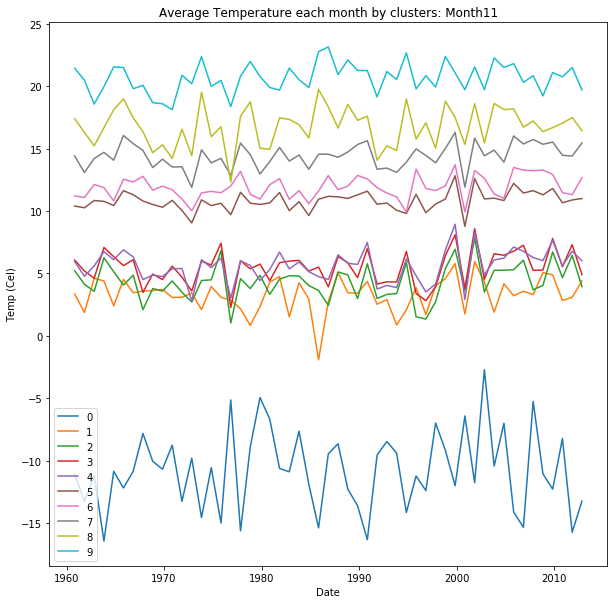

<Figure size 720x720 with 0 Axes>

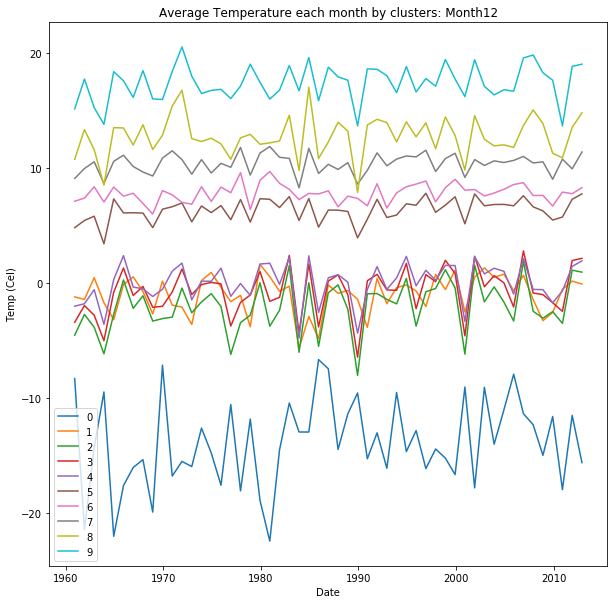

In [106]:
mainControl.getMonthDict()
import seaborn as sns
plt.figure(figsize=(10,10))
for keys in mainControl.getMonthDict().keys():
    plt.figure(figsize=(10,10))
    df = mainControl.getMonthDict()[keys]
    df = df.reset_index()
    df['LongLat'] = arrayOfDataToTrain[0]['LongLat']
    df = df.groupby(by=['dt','LongLat']).agg('mean')['AverageTemperature']

    plt.figure(figsize=(10,10))
    plt.xlabel('Date')
    plt.ylabel('Temp (Cel)')
    plt.title('Average Temperature each month by clusters: Month{}'.format(keys))
    for i in range(len(df.unstack(level=1).columns)):
        sns.lineplot(data=df.unstack(level=1)[i])
    plt.legend(range(10))
    plt.show()
    

While we have the data, might as well try out a MLP 

7318      3.251
12054     3.266
8522     13.301
10967    10.129
3482      4.771
11652    -0.412
12871     7.584
9513     -4.572
7315      4.138
4097      6.947
8521     12.642
9392     17.553
4122      5.557
10059     7.911
12941    -5.039
5522     13.829
7275     14.894
99        3.180
487      10.452
8193      8.815
2929      2.059
8276      2.398
7070     12.960
9464      5.213
2698     18.370
1393     17.887
1965      3.658
1769     -7.003
11267     5.884
9344     10.462
          ...  
5607      8.177
5978      3.655
8843     13.498
3747      9.368
2196     -0.440
8561     15.091
13463     1.697
4285     14.146
8569     15.669
10408    16.315
9832      6.808
9805      5.572
6979      6.019
1827     10.207
9154      4.970
13181    -1.295
2376     -5.791
8551     13.581
3839     -2.850
1246      6.109
7504     -5.012
6511     14.146
12472    -8.830
5439      0.352
10759     8.238
10229     8.238
12595     9.808
8964     19.180
10681     7.428
13240     3.522
Name: AverageTemperature

E:\Interpreters\Anaconda3.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7318      5.031
12054     4.377
8522     14.758
10967    10.359
3482      7.242
11652     3.435
12871    10.261
9513     -5.549
7315      6.610
4097     13.863
8521     12.187
9392     19.147
4122      9.737
10059    11.009
12941    -3.190
5522     14.923
7275     10.963
99       -0.727
487      11.956
8193     12.443
2929      0.660
8276      3.067
7070     18.684
9464      4.231
2698     21.211
1393     17.644
1965      3.610
1769     -7.608
11267    10.262
9344     10.437
          ...  
5607      7.700
5978      4.291
8843     14.485
3747     11.535
2196      1.998
8561     15.674
13463     6.517
4285     13.954
8569     16.528
10408    13.818
9832      9.593
9805      8.297
6979     10.968
1827     11.754
9154      5.127
13181     0.285
2376     -1.399
8551     13.178
3839     -1.103
1246      9.132
7504      0.015
6511     13.954
12472     2.324
5439     -2.209
10759    10.496
10229    10.496
12595    10.214
8964     18.174
10681    10.895
13240     0.846
Name: AverageTemperature

E:\Interpreters\Anaconda3.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7318     17.379
12054    12.395
8522     17.579
10967    18.460
3482     25.000
11652    24.818
12871    21.097
9513     16.878
7315     21.321
4097     25.366
8521     18.940
9392     26.722
4122     26.709
10059    26.067
12941    17.502
5522     17.382
7275     24.459
99       19.623
487      17.949
8193     16.763
2929     19.705
8276     24.989
7070     28.362
9464     14.456
2698     27.776
1393     26.598
1965     24.891
1769     20.498
11267    26.648
9344     21.259
          ...  
5607     26.651
5978     23.104
8843     28.291
3747     18.993
2196     22.197
8561     26.875
13463    22.390
4285     17.220
8569     26.815
10408    26.874
9832     25.474
9805     26.852
6979     27.727
1827     30.526
9154     21.300
13181    19.803
2376     19.690
8551     27.518
3839     19.886
1246     25.509
7504     23.751
6511     17.220
12472    24.254
5439     21.514
10759    20.276
10229    20.276
12595    27.788
8964     26.606
10681    24.017
13240    20.492
Name: AverageTemperature

E:\Interpreters\Anaconda3.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7318     22.043
12054    15.806
8522     19.395
10967    20.581
3482     25.586
11652    25.485
12871    26.726
9513     18.847
7315     22.881
4097     28.223
8521     20.380
9392     27.812
4122     29.662
10059    27.733
12941    22.479
5522     20.605
7275     26.513
99       22.895
487      18.765
8193     19.121
2929     22.747
8276     27.329
7070     28.223
9464     17.609
2698     28.599
1393     26.927
1965     24.338
1769     22.872
11267    26.904
9344     21.987
          ...  
5607     29.152
5978     24.637
8843     29.154
3747     20.538
2196     25.887
8561     28.093
13463    24.465
4285     20.696
8569     27.916
10408    28.239
9832     27.284
9805     27.632
6979     27.641
1827     31.972
9154     24.139
13181    24.028
2376     20.499
8551     28.254
3839     22.846
1246     28.045
7504     23.269
6511     20.696
12472    24.039
5439     24.123
10759    19.293
10229    19.293
12595    27.727
8964     27.574
10681    27.097
13240    25.237
Name: AverageTemperature

E:\Interpreters\Anaconda3.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7318     15.796
12054     7.346
8522     16.769
10967    15.938
3482     15.874
11652    13.984
12871    16.823
9513      8.950
7315     13.670
4097     15.021
8521     18.866
9392     25.183
4122     17.920
10059    17.248
12941    10.248
5522     17.573
7275     17.005
99       10.021
487      14.918
8193     17.959
2929     11.244
8276     16.946
7070     25.014
9464      9.715
2698     24.318
1393     24.702
1965     13.818
1769      8.381
11267    19.135
9344     18.076
          ...  
5607     17.797
5978     15.794
8843     21.517
3747     16.421
2196     13.181
8561     23.054
13463    14.812
4285     18.219
8569     23.827
10408    23.676
9832     19.663
9805     17.771
6979     18.929
1827     21.414
9154     13.985
13181    10.310
2376     11.805
8551     23.996
3839     10.912
1246     14.511
7504     12.852
6511     18.219
12472    13.321
5439     11.210
10759    15.732
10229    15.732
12595    17.988
8964     23.871
10681    21.150
13240    13.833
Name: AverageTemperature

E:\Interpreters\Anaconda3.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7318      6.039
12054     4.879
8522     17.733
10967    12.457
3482      9.549
11652     8.224
12871    12.991
9513      1.944
7315      6.957
4097      8.935
8521     16.211
9392     21.619
4122     15.129
10059    13.402
12941     3.378
5522     15.893
7275     13.204
99        6.981
487      12.984
8193     13.127
2929      6.917
8276      7.684
7070     19.701
9464      7.383
2698     19.451
1393     21.813
1965     11.834
1769      3.334
11267    10.524
9344     15.040
          ...  
5607     11.870
5978      6.665
8843     18.101
3747     13.454
2196      7.390
8561     21.622
13463    11.215
4285     17.604
8569     20.456
10408    19.774
9832     11.257
9805     11.392
6979     12.360
1827     14.057
9154      8.420
13181     4.367
2376      7.064
8551     22.089
3839      4.764
1246     13.222
7504      2.589
6511     17.604
12472     5.908
5439      5.989
10759    11.362
10229    11.362
12595    11.872
8964     20.660
10681    12.546
13240     2.247
Name: AverageTemperature

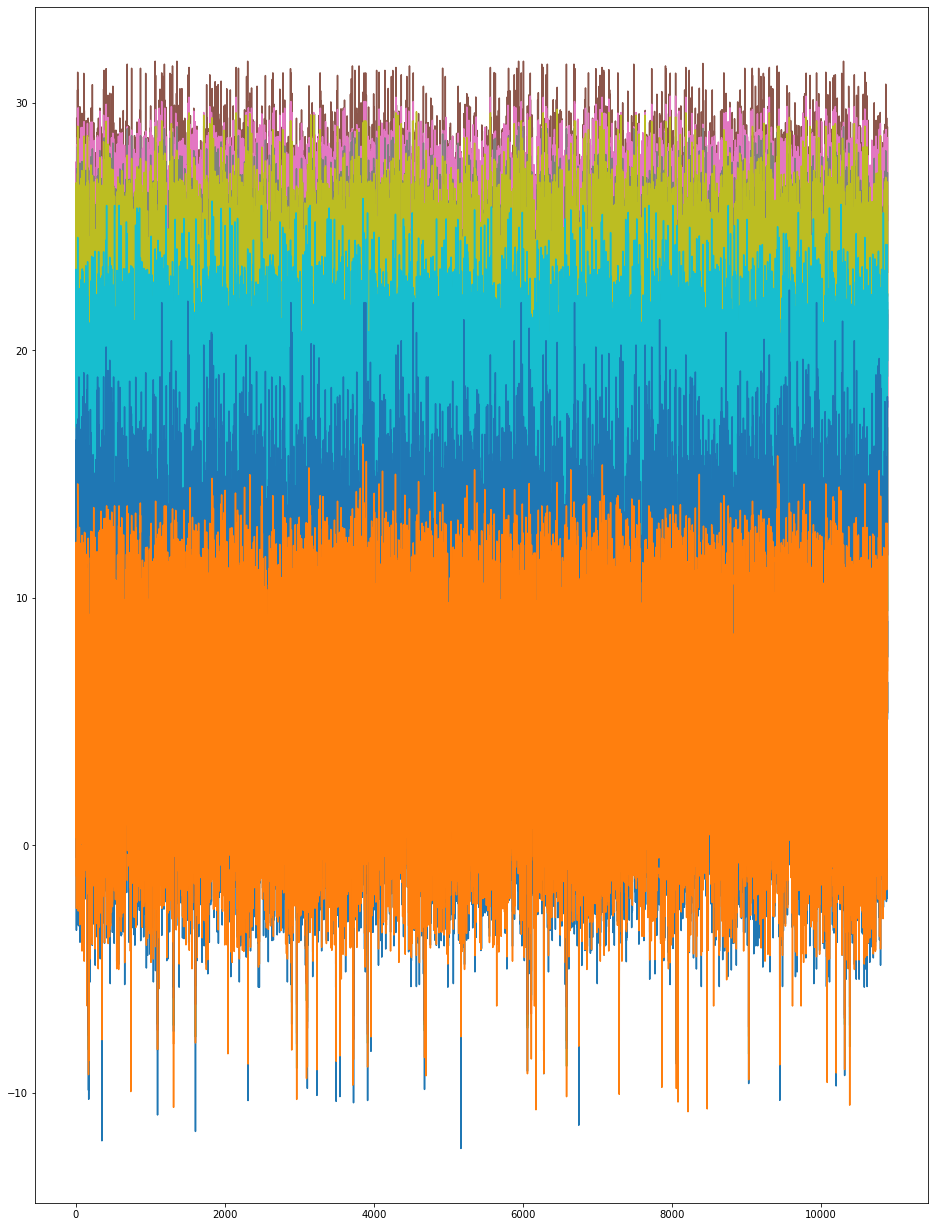

In [62]:
from sklearn.neural_network import MLPRegressor
MLPModel = []
for df in arrayOfDataToTrain:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    linMod = MLPRegressor().fit(X_train, y_train)
    MLPModel.append(linMod)
    #plt.title(f'month: {i}')
    #plt.plot(y_test, label='real')
    print(y_test)
    print(linMod.predict(X_test))
    plt.plot(linMod.predict(X_test), label='predicted')
    #plt.show()
    i+=1

Notice how we are getting strange negative numbers in the pervious data... I think there might be an issue using Longitude and Latitude in it's current state.  So let us try and fix this.  We are going to use K-Means to order our data and create zones for our longitude and latitude to be apart of.

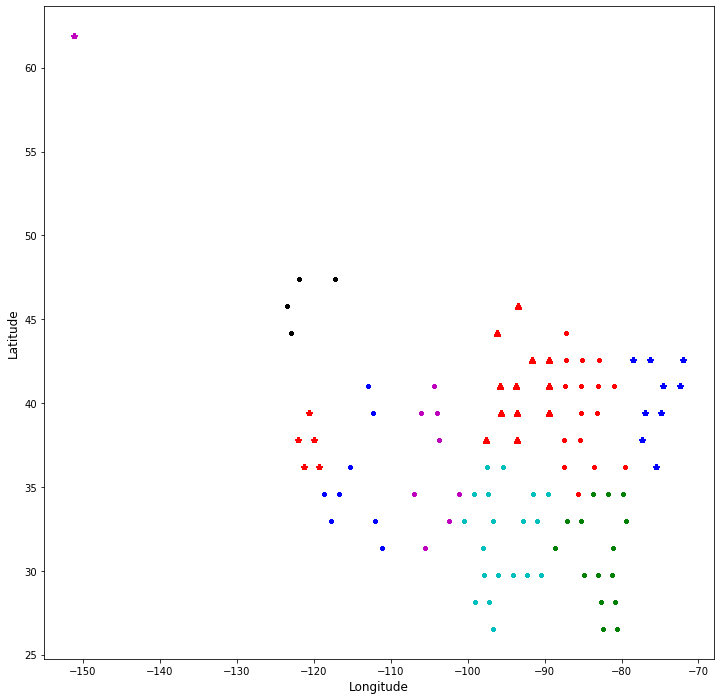

Hmm so, what are the min and max locations in regard to longitude?

In [19]:
mainControl.getMonthDict()[1].iloc[arrayOfDataToTrain[0]['Longitude'].idxmin()]
#arrayOfDataToTrain[0]['Longitude'].max()
#mainControl.getMonthDict()[1].iloc[arrayOfDataToTrain[0]['Longitude'].idxmax()]

#arrayOfDataToTrain[0]['LongLat'].unique()

AverageTemperature                     -12.961
AverageTemperatureUncertainty            0.576
City                                 Anchorage
Country                          United States
Latitude                                 61.88
Longitude                              -151.13
Name: 1960-01-01 00:00:00, dtype: object

In [20]:
monthData = arrayOfDataToTrain.copy()
for i in range(len(monthData)):
    monthData[i] = monthData[i].drop(columns=['Longitude','Latitude'])


In [21]:
MLPModel1 = []
for df in monthData:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    linMod = MLPRegressor().fit(X_train, y_train)
    MLPModel1.append(linMod)

    print(y_test)

    df['Predicted_Temp'] = linMod.predict(X_test)
    i+=1


7318      3.251
12054     3.266
8522     13.301
10967    10.129
3482      4.771
11652    -0.412
12871     7.584
9513     -4.572
7315      4.138
4097      6.947
8521     12.642
9392     17.553
4122      5.557
10059     7.911
12941    -5.039
5522     13.829
7275     14.894
99        3.180
487      10.452
8193      8.815
2929      2.059
8276      2.398
7070     12.960
9464      5.213
2698     18.370
1393     17.887
1965      3.658
1769     -7.003
11267     5.884
9344     10.462
          ...  
5607      8.177
5978      3.655
8843     13.498
3747      9.368
2196     -0.440
8561     15.091
13463     1.697
4285     14.146
8569     15.669
10408    16.315
9832      6.808
9805      5.572
6979      6.019
1827     10.207
9154      4.970
13181    -1.295
2376     -5.791
8551     13.581
3839     -2.850
1246      6.109
7504     -5.012
6511     14.146
12472    -8.830
5439      0.352
10759     8.238
10229     8.238
12595     9.808
8964     19.180
10681     7.428
13240     3.522
Name: AverageTemperature

E:\Interpreters\Anaconda3.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7318      6.197
12054     5.824
8522     13.338
10967    12.058
3482     13.161
11652     5.189
12871    12.337
9513      1.858
7315      6.984
4097     14.842
8521     14.153
9392     19.468
4122     10.919
10059    11.673
12941     0.260
5522     14.048
7275     17.505
99        3.183
487      13.067
8193     10.297
2929      7.488
8276     10.570
7070     19.507
9464      8.152
2698     21.441
1393     20.059
1965     10.003
1769     -0.761
11267    14.425
9344     11.318
          ...  
5607     11.797
5978      8.820
8843     16.615
3747     13.992
2196      6.461
8561     18.655
13463    11.294
4285     14.526
8569     17.866
10408    19.830
9832     11.241
9805     14.218
6979     11.357
1827     15.311
9154      7.149
13181     6.265
2376      5.271
8551     18.770
3839      2.872
1246     13.461
7504      5.532
6511     14.526
12472     9.212
5439      3.652
10759    12.962
10229    12.962
12595    13.996
8964     21.476
10681    13.135
13240     6.483
Name: AverageTemperature

7318      6.039
12054     4.879
8522     17.733
10967    12.457
3482      9.549
11652     8.224
12871    12.991
9513      1.944
7315      6.957
4097      8.935
8521     16.211
9392     21.619
4122     15.129
10059    13.402
12941     3.378
5522     15.893
7275     13.204
99        6.981
487      12.984
8193     13.127
2929      6.917
8276      7.684
7070     19.701
9464      7.383
2698     19.451
1393     21.813
1965     11.834
1769      3.334
11267    10.524
9344     15.040
          ...  
5607     11.870
5978      6.665
8843     18.101
3747     13.454
2196      7.390
8561     21.622
13463    11.215
4285     17.604
8569     20.456
10408    19.774
9832     11.257
9805     11.392
6979     12.360
1827     14.057
9154      8.420
13181     4.367
2376      7.064
8551     22.089
3839      4.764
1246     13.222
7504      2.589
6511     17.604
12472     5.908
5439      5.989
10759    11.362
10229    11.362
12595    11.872
8964     20.660
10681    12.546
13240     2.247
Name: AverageTemperature